In [4]:
# Cell 1: HMM Training
import json
from collections import defaultdict
import time

print("Starting HMM training...")
start_time = time.time()

def preprocess_corpus(file_path):
    """Reads a text file and returns a clean list of words."""
    try:
        with open(file_path, 'r') as f:
            words = [line.strip().lower() for line in f if line.strip().isalpha()]
        print(f"Successfully processed {len(words)} words from {file_path}.")
        return words
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return []

def group_by_length(words):
    """Groups words by their length."""
    words_by_length = defaultdict(list)
    for word in words:
        words_by_length[len(word)].append(word)
    return words_by_length

def train_hmm(words_by_length):
    """
    Trains a separate HMM for each word length based on initial and transition probabilities.
    """
    hmm_model = {}
    alphabet = 'abcdefghijklmnopqrstuvwxyz'

    for length, words in words_by_length.items():
        # Initialize probabilities
        initial_probs = {char: 0 for char in alphabet}
        transition_probs = {char: {char2: 0 for char2 in alphabet} for char in alphabet}
        char_counts = {char: 0 for char in alphabet}

        # Calculate initial state probabilities (pi) [cite: 17, 18]
        for word in words:
            if word:
                initial_probs[word[0]] += 1

        # Calculate transition probabilities (A) [cite: 17, 18]
        for word in words:
            for i in range(len(word) - 1):
                current_char = word[i]
                next_char = word[i+1]
                transition_probs[current_char][next_char] += 1
                char_counts[current_char] += 1

        # Normalize probabilities to get a distribution
        num_words = len(words)
        normalized_initial = {char: count / num_words for char, count in initial_probs.items()}

        normalized_transitions = {}
        for char, transitions in transition_probs.items():
            total_transitions = char_counts[char]
            normalized_transitions[char] = {
                next_char: count / total_transitions if total_transitions > 0 else 0
                for next_char, count in transitions.items()
            }

        hmm_model[length] = {
            'initial': normalized_initial,
            'transitions': normalized_transitions
        }

    return hmm_model

# --- Main Execution ---
corpus_words = preprocess_corpus('corpus.txt')
words_by_length = group_by_length(corpus_words)

# Train and save the HMM
hmm = train_hmm(words_by_length)

with open('hmm_model.json', 'w') as f:
    json.dump(hmm, f, indent=4)
print("HMM model successfully trained and saved to hmm_model.json")

# Process and save the test words for the final evaluation step
test_words = preprocess_corpus('test.txt')
with open('clean_test_words.json', 'w') as f:
    json.dump(test_words, f)
print("Clean test words saved to clean_test_words.json for evaluation.")

end_time = time.time()
print(f"HMM Training finished in {end_time - start_time:.2f} seconds.")

Starting HMM training...
Successfully processed 49979 words from corpus.txt.
HMM model successfully trained and saved to hmm_model.json
Successfully processed 2000 words from test.txt.
Clean test words saved to clean_test_words.json for evaluation.
HMM Training finished in 0.13 seconds.


In [5]:
# Cell 2: Environment and Agent Classes
import json
import random
from collections import defaultdict

# --- Hangman Environment Class ---
class HangmanEnv:
    """A simple Hangman game environment for the RL agent."""
    def __init__(self, max_wrong_guesses=6):
        self.max_wrong_guesses = max_wrong_guesses
        self.word_to_guess = ""
        self.masked_word = []
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')

    def reset(self, word):
        """Resets the environment with a new word."""
        self.word_to_guess = word
        self.masked_word = ['_'] * len(word)
        self.guessed_letters = set()
        self.wrong_guesses = 0
        return self._get_state()

    def _get_state(self):
        """Returns the current state of the game as a hashable tuple."""
        return ("".join(self.masked_word), frozenset(self.guessed_letters), self.wrong_guesses)

    def step(self, action_letter):
        """
        Takes an action (guessing a letter) and returns the new state,
        reward, and whether the game is done.
        """
        self.guessed_letters.add(action_letter)

        if action_letter in self.word_to_guess:
            # Correct guess
            is_new_letter = False
            for i, char in enumerate(self.word_to_guess):
                if char == action_letter:
                    if self.masked_word[i] == '_':
                        is_new_letter = True
                    self.masked_word[i] = action_letter

            # Positive reward only for revealing new letters
            reward = 1 if is_new_letter else 0

            done = '_' not in self.masked_word
            if done:
                reward = 2000 # Large reward for winning [cite: 44]
        else:
            # Incorrect guess
            self.wrong_guesses += 1
            reward = -5 # Penalty for wrong guesses [cite: 44]
            done = self.wrong_guesses >= self.max_wrong_guesses
            if done:
                reward = -2000 # Large penalty for losing to balance the win reward

        return self._get_state(), reward, done

    def get_possible_actions(self):
        """Returns the set of letters that haven't been guessed yet."""
        return self.alphabet - self.guessed_letters

# --- RL Agent Class ---
class RLAgent:
    """A Q-learning agent that uses an HMM as an oracle."""
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.9):
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.actions = actions # Full alphabet
        self.alpha = alpha # Learning rate
        self.gamma = gamma # Discount factor
        self.epsilon = epsilon # Exploration rate
        self.hmm_model = self._load_hmm_model('hmm_model.json')

    def _load_hmm_model(self, filename):
        """Loads the pre-trained HMM."""
        try:
            with open(filename, 'r') as f:
                return json.load(f)
        except FileNotFoundError:
            print(f"CRITICAL ERROR: HMM model file '{filename}' not found. Cannot proceed.")
            return None

    def get_hmm_probabilities(self, state):
        """Uses the HMM to get a probability distribution over possible next letters."""
        masked_word, guessed_letters, _ = state
        word_len_str = str(len(masked_word))
        possible_actions = self.actions - guessed_letters

        if not self.hmm_model or word_len_str not in self.hmm_model:
            return {action: 1 / len(possible_actions) for action in possible_actions}

        hmm_for_length = self.hmm_model[word_len_str]
        initial_probs = hmm_for_length['initial']
        transition_probs = hmm_for_length['transitions']

        scores = defaultdict(float)

        for letter in possible_actions:
            score = 0.0
            for i, char in enumerate(masked_word):
                if char == '_':
                    # Get neighbors
                    before_char = masked_word[i-1] if i > 0 and masked_word[i-1] != '_' else None
                    after_char = masked_word[i+1] if i < len(masked_word) - 1 and masked_word[i+1] != '_' else None

                    if i == 0: # First letter
                        prob = initial_probs.get(letter, 0)
                        if after_char:
                            prob *= transition_probs.get(letter, {}).get(after_char, 0)
                    else: # Not the first letter
                        if before_char:
                            prob = transition_probs.get(before_char, {}).get(letter, 0)
                            if after_char:
                                prob *= transition_probs.get(letter, {}).get(after_char, 0)
                        else: # No left neighbor (e.g., '__B'), use a generic guess
                            prob = 1 / len(possible_actions)
                    score += prob
            scores[letter] = score

        total_score = sum(scores.values())
        if total_score == 0:
            return {action: 1 / len(possible_actions) for action in possible_actions}

        return {k: v / total_score for k, v in scores.items()}

    def choose_action(self, state):
        """Chooses an action using an epsilon-greedy policy combined with the HMM."""
        _, guessed_letters, _ = state
        possible_actions = list(self.actions - guessed_letters)

        if not possible_actions: return None

        # Exploration vs. Exploitation [cite: 56, 70]
        if random.uniform(0, 1) < self.epsilon:
            # Exploration: Choose a random action
            return random.choice(possible_actions)
        else:
            # Exploitation: Choose the best action
            q_values_for_state = self.q_table[state]

            # If we have no Q-values for this state, fall back to the HMM
            if all(q_values_for_state.get(action, 0) == 0 for action in possible_actions):
                hmm_probs = self.get_hmm_probabilities(state)
                return max(hmm_probs, key=hmm_probs.get, default=random.choice(possible_actions))

            # Find the action with the highest Q-value
            max_q = -float('inf')
            best_action = None
            for action in possible_actions:
                q_val = q_values_for_state.get(action, 0)
                if q_val > max_q:
                    max_q = q_val
                    best_action = action
            return best_action or random.choice(possible_actions)

    def learn(self, state, action, reward, next_state):
        """Updates the Q-table using the Bellman equation."""
        q_values_for_next_state = self.q_table[next_state]
        max_q_next = max(q_values_for_next_state.values()) if q_values_for_next_state else 0.0

        old_q_value = self.q_table[state][action]
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_q_next - old_q_value)
        self.q_table[state][action] = new_q_value

    def save_q_table(self, filename='q_table.json'):
        """Saves the Q-table to a file."""
        serializable_q_table = {
            str((s[0], list(s[1]), s[2])): v for s, v in self.q_table.items()
        }
        with open(filename, 'w') as f:
            json.dump(serializable_q_table, f)

    def load_q_table(self, filename='q_table.json'):
        """Loads the Q-table from a file."""
        try:
            with open(filename, 'r') as f:
                loaded_table = json.load(f)

            self.q_table = defaultdict(lambda: defaultdict(float))
            for k, v in loaded_table.items():
                 state_tuple_str = eval(k)
                 state_tuple = (state_tuple_str[0], frozenset(state_tuple_str[1]), state_tuple_str[2])
                 self.q_table[state_tuple] = defaultdict(float, v)
            print(f"Q-table loaded successfully from {filename}")
        except FileNotFoundError:
            print("No existing Q-table found. Starting a new training session.")

print("Environment and Agent classes defined.")

Environment and Agent classes defined.


In [6]:
# Cell 3: Agent Training Loop
import json
import random
from tqdm import tqdm
import time

print("Starting agent training...")
start_time = time.time()

# Load the corpus for training
with open('corpus.txt', 'r') as f:
    word_list = [line.strip().lower() for line in f if line.strip().isalpha()]

# Initialize environment and agent
env = HangmanEnv()
agent = RLAgent(actions=env.alphabet, epsilon=0.9) # Start with high exploration
agent.load_q_table() # Load previous progress if it exists

# Training parameters
episodes = 50000
epsilon_decay_rate = 0.99995 # Slower decay for more exploration
min_epsilon = 0.05
save_interval = 2000

# --- Training Loop ---
for episode in range(episodes):
    word = random.choice(word_list)
    state = env.reset(word)
    done = False

    # Run a single game (episode)
    while not done:
        action = agent.choose_action(state)
        if action is None:
            break

        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state

    # Decay epsilon to reduce exploration over time
    agent.epsilon = max(min_epsilon, agent.epsilon * epsilon_decay_rate)

    # Progress update and saving the Q-table
    if (episode + 1) % save_interval == 0:
        print(f"\nEpisode {episode + 1}/{episodes} | Epsilon: {agent.epsilon:.4f}")
        agent.save_q_table()

# Final save
agent.save_q_table()
end_time = time.time()
print(f"\nTraining complete! Total time: {(end_time - start_time) / 60:.2f} minutes.")

Starting agent training...
No existing Q-table found. Starting a new training session.

Episode 2000/50000 | Epsilon: 0.8144

Episode 4000/50000 | Epsilon: 0.7369

Episode 6000/50000 | Epsilon: 0.6667

Episode 8000/50000 | Epsilon: 0.6033

Episode 10000/50000 | Epsilon: 0.5459

Episode 12000/50000 | Epsilon: 0.4939

Episode 14000/50000 | Epsilon: 0.4469

Episode 16000/50000 | Epsilon: 0.4044

Episode 18000/50000 | Epsilon: 0.3659

Episode 20000/50000 | Epsilon: 0.3311

Episode 22000/50000 | Epsilon: 0.2996

Episode 24000/50000 | Epsilon: 0.2711

Episode 26000/50000 | Epsilon: 0.2453

Episode 28000/50000 | Epsilon: 0.2219

Episode 30000/50000 | Epsilon: 0.2008

Episode 32000/50000 | Epsilon: 0.1817

Episode 34000/50000 | Epsilon: 0.1644

Episode 36000/50000 | Epsilon: 0.1488

Episode 38000/50000 | Epsilon: 0.1346

Episode 40000/50000 | Epsilon: 0.1218

Episode 42000/50000 | Epsilon: 0.1102

Episode 44000/50000 | Epsilon: 0.0997

Episode 46000/50000 | Epsilon: 0.0902

Episode 48000/50000

In [7]:
# Cell 4: Final Evaluation
import json
from tqdm import tqdm
import time

print("Starting final evaluation...")
start_time = time.time()

# Load the clean test words
try:
    with open('clean_test_words.json', 'r') as f:
        test_words = json.load(f)
    # The problem statement says 2000 games [cite: 42]
    # The provided test.txt has 2000 words. We'll use all of them.
    num_games = len(test_words)
    print(f"Loaded {num_games} words for evaluation.")
except FileNotFoundError:
    print("Error: clean_test_words.json not found. Cannot evaluate.")
    # Exit gracefully if the file isn't there
    exit()

# Initialize the environment and load the trained agent
env = HangmanEnv()
agent = RLAgent(actions=env.alphabet, epsilon=0)  # Epsilon = 0 for pure exploitation
agent.load_q_table('q_table.json')

total_wins = 0
total_wrong_guesses = 0
total_repeated_guesses = 0 # This should be 0 due to our agent's design

# --- Evaluation Loop ---
for word in tqdm(test_words, desc="Evaluating Agent"):
    state = env.reset(word)
    done = False

    current_game_guesses = set()
    while not done:
        action = agent.choose_action(state)
        if action is None:
            break

        # Although the agent logic prevents repeats, this is a safety check.
        if action in current_game_guesses:
            total_repeated_guesses += 1
            # If a repeat happens, the agent needs to pick a different action
            # This part of the code should ideally never be reached
            possible_actions = env.get_possible_actions()
            if possible_actions:
                action = random.choice(list(possible_actions))
            else:
                break

        current_game_guesses.add(action)
        state, _, done = env.step(action)

    # Check game outcome
    if '_' not in env.masked_word:
        total_wins += 1

    total_wrong_guesses += env.wrong_guesses

# --- Calculate Final Score ---
success_rate = total_wins / num_games if num_games > 0 else 0

# Formula from the problem statement [cite: 44]
final_score = (success_rate * 2000) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

# --- Print Final Report ---
print("\n" + "="*40)
print("          FINAL HACKATHON RESULTS          ")
print("="*40)
print(f"Total Games Played:      {num_games}")
print(f"Success Rate:            {success_rate:.2%}")
print(f"Total Games Won:         {total_wins}")
print("-" * 20)
print(f"Total Wrong Guesses:     {total_wrong_guesses}")
print(f"Avg Wrong Guesses/Game:  {total_wrong_guesses / num_games:.2f}")
print(f"Total Repeated Guesses:  {total_repeated_guesses} (Should be 0)")
print("="*40)
print(f"🏆 FINAL SCORE:          {final_score:.2f}")
print("="*40)

end_time = time.time()
print(f"Evaluation finished in {end_time - start_time:.2f} seconds.")

Starting final evaluation...
Loaded 2000 words for evaluation.
Q-table loaded successfully from q_table.json


Evaluating Agent: 100%|██████████| 2000/2000 [00:00<00:00, 2278.67it/s]


          FINAL HACKATHON RESULTS          
Total Games Played:      2000
Success Rate:            30.20%
Total Games Won:         604
--------------------
Total Wrong Guesses:     10569
Avg Wrong Guesses/Game:  5.28
Total Repeated Guesses:  0 (Should be 0)
🏆 FINAL SCORE:          -52241.00
Evaluation finished in 13.54 seconds.


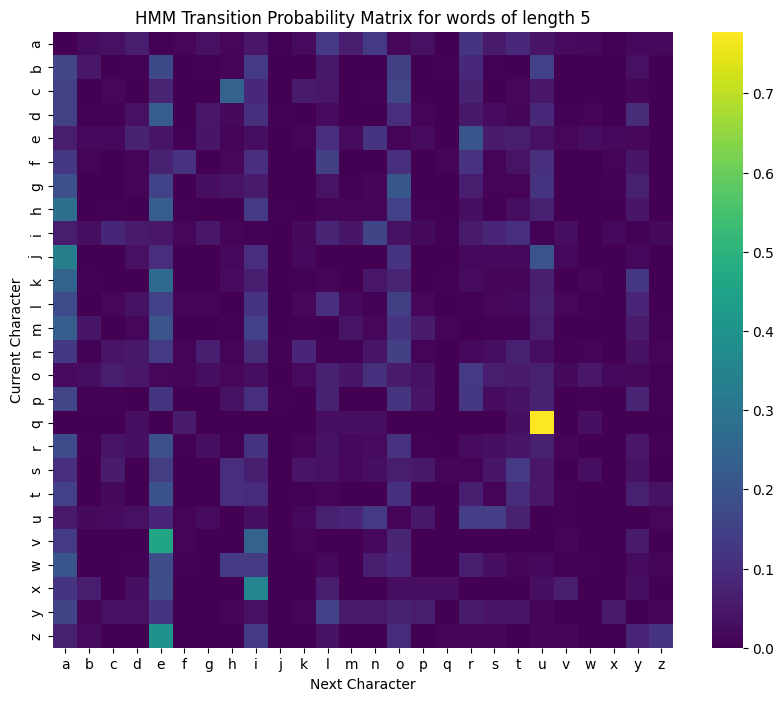

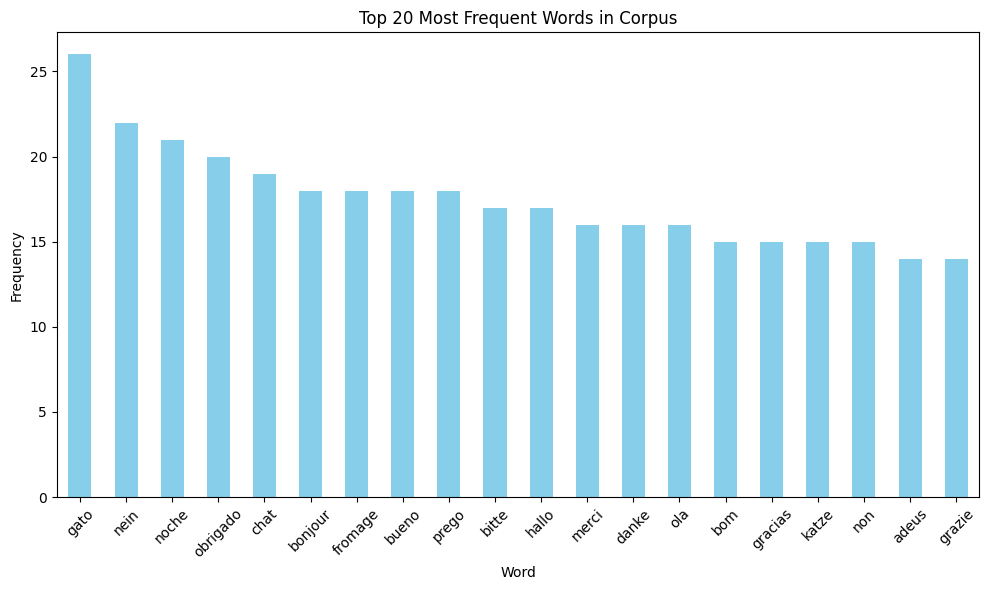

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extracting transition probabilities from the HMM model for visualization
# We'll visualize transitions for a specific word length, e.g., length 5 for demonstration
# The HMM model contains transitions for various lengths. Let's pick a length that has been trained.

# Load the HMM model if it's not already in memory (it should be from Cell 1)
try:
    with open('hmm_model.json', 'r') as f:
        hmm_model_data = json.load(f)
except FileNotFoundError:
    print("HMM model file 'hmm_model.json' not found. Please ensure Cell 1 runs successfully.")
    hmm_model_data = {}

# Choose a word length for visualization. Using 5 as an example.
# We can make this dynamic or plot for multiple lengths if needed.
selected_length = "5" # The keys in hmm_model_data are strings of lengths

if selected_length in hmm_model_data:
    transitions_for_length = hmm_model_data[selected_length]['transitions']

    # Create a DataFrame for the transition matrix
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    transition_matrix = np.zeros((len(alphabet), len(alphabet)))
    char_to_idx = {char: i for i, char in enumerate(alphabet)}

    for current_char, next_char_probs in transitions_for_length.items():
        if current_char in char_to_idx:
            for next_char, prob in next_char_probs.items():
                if next_char in char_to_idx:
                    transition_matrix[char_to_idx[current_char], char_to_idx[next_char]] = prob

    transition_df = pd.DataFrame(transition_matrix, index=list(alphabet), columns=list(alphabet))

    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_df, cmap="viridis", annot=False, fmt=".2f")
    plt.title(f"HMM Transition Probability Matrix for words of length {selected_length}")
    plt.xlabel("Next Character")
    plt.ylabel("Current Character")
    plt.show()
else:
    print(f"No HMM data found for word length {selected_length}. Cannot visualize transition matrix.")

# The original example for emission_matrix and word_freq are commented out or not directly applicable without further context.
# emission_df = pd.DataFrame(emission_matrix)
# plt.figure(figsize=(8,6))
# sns.heatmap(emission_df, cmap="magma")
# plt.title("HMM Emission Probability Matrix")
# plt.xlabel("Observed Symbol")
# plt.ylabel("Hidden State")
# plt.show()

# Example: word frequency bar chart
# Assuming `word_list` from Cell 3 is available in the kernel
if 'word_list' in locals() or 'word_list' in globals():
    word_freq = pd.Series(word_list).value_counts().head(20)
    plt.figure(figsize=(10, 6))
    word_freq.plot(kind='bar', color='skyblue')
    plt.title("Top 20 Most Frequent Words in Corpus")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("word_list not found. Cannot plot word frequency.")


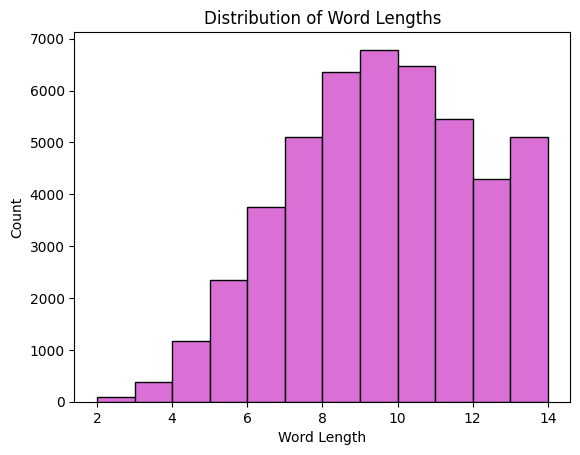

In [20]:
# Distribution of word lengths
word_lengths = [len(w) for w in word_list]
plt.hist(word_lengths, bins=range(2,15), color='orchid', edgecolor='black')
plt.title("Distribution of Word Lengths")
plt.xlabel("Word Length")
plt.ylabel("Count")
plt.show()

# (Optional) Game state transitions heatmap (if you record transitions)
# state_counts = pd.crosstab(game_states['from'], game_states['to'])
# sns.heatmap(state_counts, cmap='coolwarm')
# plt.title("State Transition Frequencies")
# plt.show()


Generating performance visualizations...
Q-table loaded successfully from q_table.json
✅ Visualization saved as 'hangman_performance_analysis.png'


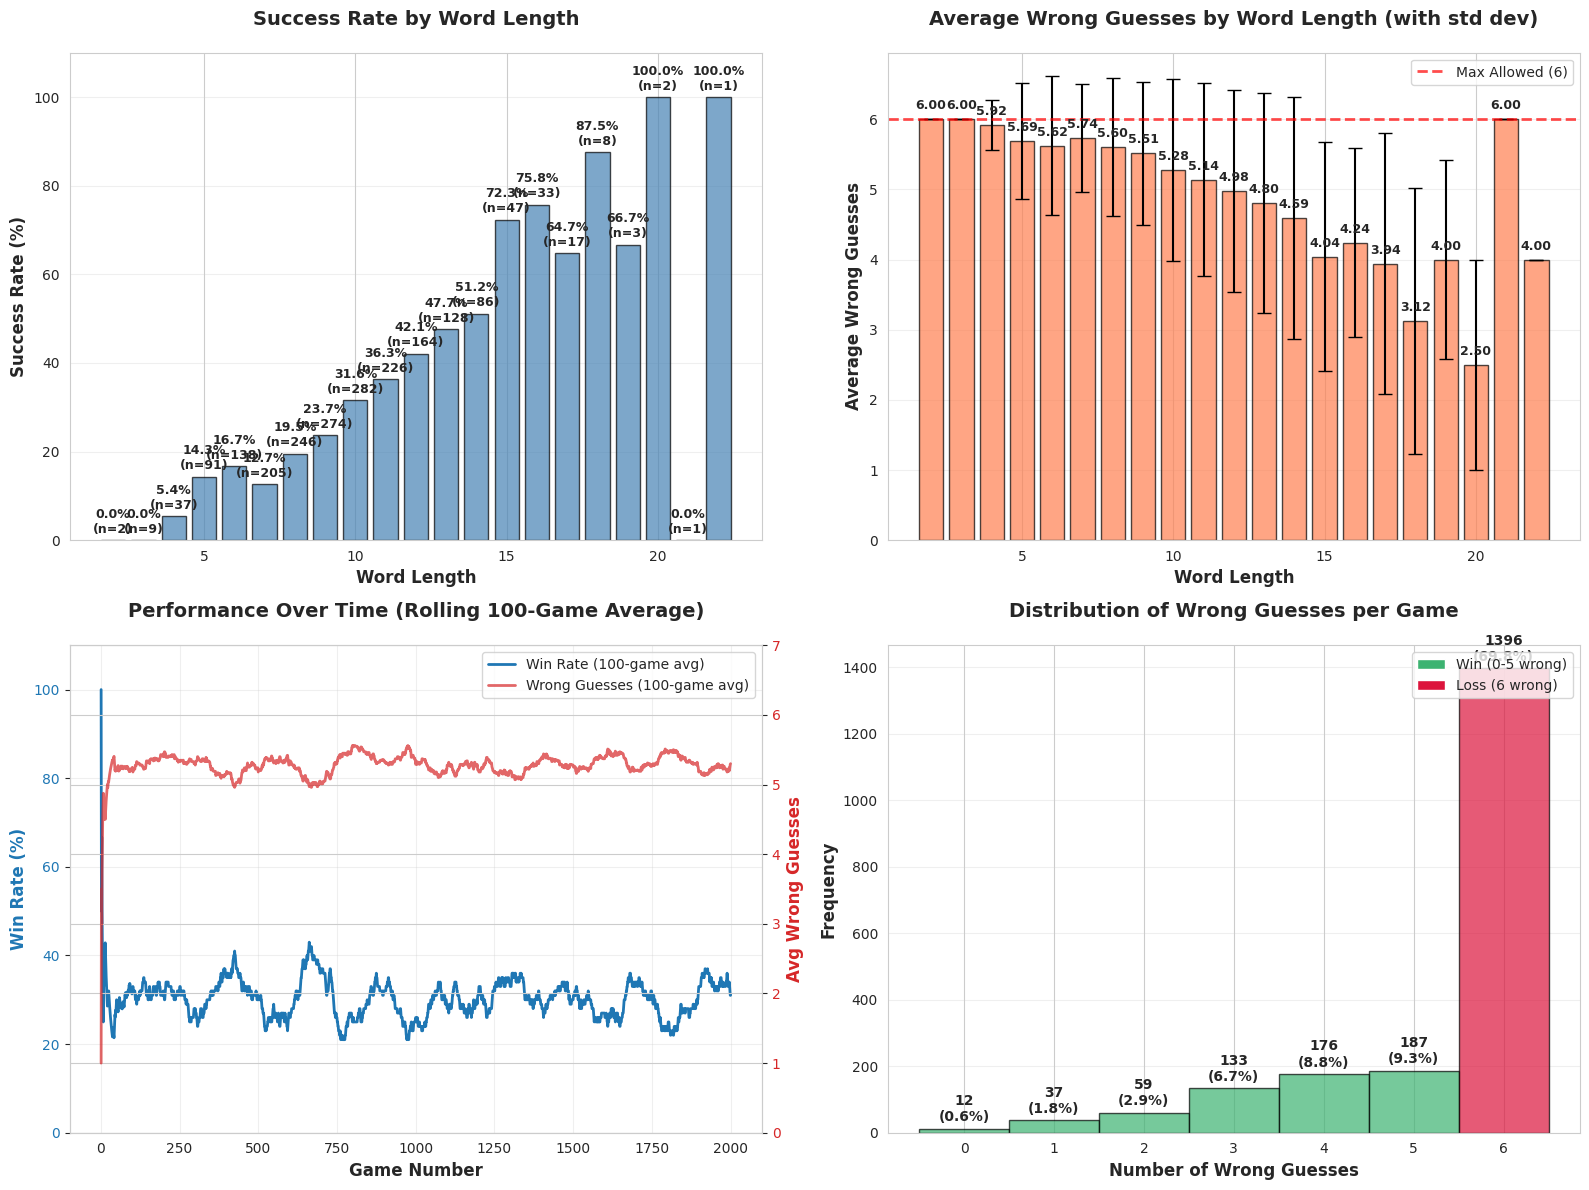


                  DETAILED STATISTICS

Performance by Word Length:
------------------------------------------------------------
Length   Games    Win Rate     Avg Wrong    Std Dev   
------------------------------------------------------------
2        2          0.00%       6.00         0.00
3        9          0.00%       6.00         0.00
4        37         5.41%       5.92         0.36
5        91        14.29%       5.69         0.82
6        138       16.67%       5.62         0.99
7        205       12.68%       5.74         0.77
8        246       19.51%       5.60         0.98
9        274       23.72%       5.51         1.02
10       282       31.56%       5.28         1.30
11       226       36.28%       5.14         1.37
12       164       42.07%       4.98         1.44
13       128       47.66%       4.80         1.57
14       86        51.16%       4.59         1.72
15       47        72.34%       4.04         1.64
16       33        75.76%       4.24         1.35
17   

In [24]:
# Cell 5: Performance Visualization
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

print("Generating performance visualizations...")

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# Load the clean test words and prepare data
with open('clean_test_words.json', 'r') as f:
    test_words = json.load(f)

# Initialize environment and agent
env = HangmanEnv()
agent = RLAgent(actions=env.alphabet, epsilon=0)
agent.load_q_table('q_table.json')

# Data collection structures
word_length_stats = defaultdict(lambda: {'total': 0, 'wins': 0, 'wrong_guesses': []})
game_results = []  # List of tuples: (game_number, won, wrong_guesses)

# Run evaluation and collect detailed stats
print("Collecting detailed statistics...")
for idx, word in enumerate(test_words):
    state = env.reset(word)
    done = False

    while not done:
        action = agent.choose_action(state)
        if action is None:
            break
        state, _, done = env.step(action)

    # Record results
    word_len = len(word)
    won = '_' not in env.masked_word
    wrong_guesses = env.wrong_guesses

    word_length_stats[word_len]['total'] += 1
    if won:
        word_length_stats[word_len]['wins'] += 1
    word_length_stats[word_len]['wrong_guesses'].append(wrong_guesses)

    game_results.append((idx + 1, won, wrong_guesses))

# Create figure with subplots
fig = plt.figure(figsize=(16, 12))

# ==================== PLOT 1: Success Rate by Word Length ====================
ax1 = plt.subplot(2, 2, 1)
word_lengths = sorted(word_length_stats.keys())
success_rates = [
    (word_length_stats[length]['wins'] / word_length_stats[length]['total']) * 100
    for length in word_lengths
]
game_counts = [word_length_stats[length]['total'] for length in word_lengths]

bars = ax1.bar(word_lengths, success_rates, color='steelblue', alpha=0.7, edgecolor='black')

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, game_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%\n(n={count})',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_xlabel('Word Length', fontsize=12, fontweight='bold')
ax1.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Success Rate by Word Length', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylim(0, 110)
ax1.grid(axis='y', alpha=0.3)

# ==================== PLOT 2: Average Wrong Guesses by Word Length ====================
ax2 = plt.subplot(2, 2, 2)
avg_wrong_guesses = [
    np.mean(word_length_stats[length]['wrong_guesses']) if word_length_stats[length]['wrong_guesses'] else 0
    for length in word_lengths
]
std_wrong_guesses = [
    np.std(word_length_stats[length]['wrong_guesses']) if len(word_length_stats[length]['wrong_guesses']) > 1 else 0
    for length in word_lengths
]

bars2 = ax2.bar(word_lengths, avg_wrong_guesses, yerr=std_wrong_guesses,
                color='coral', alpha=0.7, edgecolor='black', capsize=5)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_xlabel('Word Length', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Wrong Guesses', fontsize=12, fontweight='bold')
ax2.set_title('Average Wrong Guesses by Word Length (with std dev)',
              fontsize=14, fontweight='bold', pad=20)
ax2.axhline(y=6, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Max Allowed (6)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# ==================== PLOT 3: Performance Over Time (Rolling Average) ====================
ax3 = plt.subplot(2, 2, 3)
window_size = 100  # Rolling window for smoothing

game_numbers = [x[0] for x in game_results]
wins = [1 if x[1] else 0 for x in game_results]
wrong_guesses_over_time = [x[2] for x in game_results]

# Calculate rolling averages
rolling_win_rate = []
rolling_wrong_guesses = []

for i in range(len(game_results)):
    start_idx = max(0, i - window_size + 1)
    window_wins = wins[start_idx:i+1]
    window_wrong = wrong_guesses_over_time[start_idx:i+1]

    rolling_win_rate.append(np.mean(window_wins) * 100)
    rolling_wrong_guesses.append(np.mean(window_wrong))

# Plot win rate
color = 'tab:blue'
ax3.set_xlabel('Game Number', fontsize=12, fontweight='bold')
ax3.set_ylabel('Win Rate (%)', color=color, fontsize=12, fontweight='bold')
line1 = ax3.plot(game_numbers, rolling_win_rate, color=color, linewidth=2,
                 label=f'Win Rate ({window_size}-game avg)')
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(0, 110)
ax3.grid(alpha=0.3)

# Plot wrong guesses on secondary axis
ax3_twin = ax3.twinx()
color = 'tab:red'
ax3_twin.set_ylabel('Avg Wrong Guesses', color=color, fontsize=12, fontweight='bold')
line2 = ax3_twin.plot(game_numbers, rolling_wrong_guesses, color=color,
                      linewidth=2, alpha=0.7, label=f'Wrong Guesses ({window_size}-game avg)')
ax3_twin.tick_params(axis='y', labelcolor=color)
ax3_twin.set_ylim(0, 7)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper right')

ax3.set_title(f'Performance Over Time (Rolling {window_size}-Game Average)',
              fontsize=14, fontweight='bold', pad=20)

# ==================== PLOT 4: Distribution of Wrong Guesses ====================
ax4 = plt.subplot(2, 2, 4)
all_wrong_guesses = [x[2] for x in game_results]

# Create histogram
counts, bins, patches = ax4.hist(all_wrong_guesses, bins=range(0, 8),
                                  color='mediumseagreen', alpha=0.7,
                                  edgecolor='black', align='left')

# Color the bars - green for wins (0-5 wrong), red for losses (6+)
for i, patch in enumerate(patches):
    if i >= 6:
        patch.set_facecolor('crimson')

# Add value labels on bars
for i, count in enumerate(counts):
    if count > 0:
        ax4.text(i, count + max(counts) * 0.01, f'{int(count)}\n({count/len(all_wrong_guesses)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax4.set_xlabel('Number of Wrong Guesses', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Distribution of Wrong Guesses per Game', fontsize=14, fontweight='bold', pad=20)
ax4.set_xticks(range(0, 7))
ax4.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='mediumseagreen', label='Win (0-5 wrong)'),
                   Patch(facecolor='crimson', label='Loss (6 wrong)')]
ax4.legend(handles=legend_elements, loc='upper right')

# ==================== Final Adjustments ====================
plt.tight_layout()
plt.savefig('hangman_performance_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'hangman_performance_analysis.png'")
plt.show()

# ==================== Print Summary Statistics ====================
print("\n" + "="*60)
print("                  DETAILED STATISTICS")
print("="*60)
print("\nPerformance by Word Length:")
print("-" * 60)
print(f"{'Length':<8} {'Games':<8} {'Win Rate':<12} {'Avg Wrong':<12} {'Std Dev':<10}")
print("-" * 60)
for length in word_lengths:
    stats = word_length_stats[length]
    win_rate = (stats['wins'] / stats['total']) * 100
    avg_wrong = np.mean(stats['wrong_guesses']) if stats['wrong_guesses'] else 0
    std_wrong = np.std(stats['wrong_guesses']) if len(stats['wrong_guesses']) > 1 else 0
    print(f"{length:<8} {stats['total']:<8} {win_rate:>6.2f}%     {avg_wrong:>6.2f}       {std_wrong:>6.2f}")

print("\n" + "="*60)
print(f"Most Challenging Length: {max(word_lengths, key=lambda x: np.mean(word_length_stats[x]['wrong_guesses']))}")
print(f"Best Performance Length: {max(word_lengths, key=lambda x: word_length_stats[x]['wins']/word_length_stats[x]['total'])}")
print("="*60)